In [1]:
from fourInRowGame import Chip, FourInRowGame
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
def CreateBoardStates(nbrows,nbcolumns):   
    #boardstate is a list where all (x,y) are stored. The order is row major. It means that each line is concatainated.
    boardstate=[]
    count=0
    for y in range(nbrows):
        for x in range(nbcolumns):
            boardstate.append((x,y))
    return boardstate

def getXYfromAgentState(agentstate,boardstate):
    xy=boardstate[agentstate]
    return xy

def getAgentStateFromXY(x,y,boardstate):
    return boardstate.index((x,y))

def target_policy(action_values, state):
    av = action_values[state]
    return np.random.choice(np.flatnonzero(av == av.max()))

def exploratory_policy(possible_actions): 
    return np.random.choice(possible_actions)

def get_possible_actions(env, ncol, nrow, done): 
    no_pos_action = True
    actions = np.array([])
    for col in range(ncol):
        if env.column_height(col) < nrow:
            actions = np.append(actions, np.array([col]))
            no_pos_action = False
    if no_pos_action:
        done = True
    return([actions.astype(int), done])

def getNextState(board_now, board_before, boardstate, getAgentStateFromXY):
    board_diff = board_now - board_before
    change = np.argwhere(board_diff != 0)
    next_state = getAgentStateFromXY(change[0][1], change[0][0], boardstate)
    return(next_state)

def makeUpdate(player, state, action_values, env, nrow, ncol, alpha, gamma, done, 
               get_possible_actions, getNextState, exploratory_policy, target_policy, getAgentStateFromXY):
    board_before = env.get_simple_slots()
    possible_actions, done = get_possible_actions(env, ncol, nrow, done)
    if done: 
        return([env, action_values, state, done])
    action = exploratory_policy(possible_actions)
    if player == 1:
        env.drop(Chip.YELLOW, action)
    elif player == 2:
        env.drop(Chip.RED, action)
    else: 
        raise Exeption("Wrong Player Number")
    next_state = getNextState(env.get_simple_slots(), board_before, boardstate, getAgentStateFromXY)
    check_victory = env.check_for_victory()
    if check_victory: 
        reward = 10
        done = True
    else: 
        reward = -1
    next_action = target_policy(action_values, next_state)
    
    qsa = action_values[state][action]
    next_qsa = action_values[next_state][next_action]
    action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
    state = next_state
    return([env, action_values, state, done])

def q_learning_one_game(av1, av2, env, boardstate, exploratory_policy, target_policy, 
                        get_possible_actions, getNextState, nrow, ncol, alpha = 0.1, gamma = 0.99):
    env.reset()
    state = 0
    done = False
    while not done:
        # Player 1 (Yellow): 
        env, av1, next_state, done = makeUpdate(1, 
                                                state, 
                                                av1, 
                                                env, 
                                                nrow, 
                                                ncol, 
                                                alpha, 
                                                gamma, 
                                                done, 
                                                get_possible_actions, 
                                                getNextState, 
                                                exploratory_policy, 
                                                target_policy, 
                                                getAgentStateFromXY)


        if done: 
            break
        state = next_state
        
        # Player 2 (Red): 
        env, av2, next_state, done = makeUpdate(2, 
                                                state, 
                                                av2, 
                                                env, 
                                                nrow, 
                                                ncol, 
                                                alpha, 
                                                gamma, 
                                                done, 
                                                get_possible_actions, 
                                                getNextState, 
                                                exploratory_policy, 
                                                target_policy, 
                                                getAgentStateFromXY)
        state = next_state
    return([av1, av2])


def playManyGames(env, niter, boardstate, nrow, ncol, exploratory_policy, target_policy, 
                  get_possible_actions, getNextState):
    action_values1 = np.zeros((len(boardstate), ncol))
    action_values2 = np.zeros((len(boardstate), ncol))
    for iter in range(niter):
        action_values1, action_values2 = q_learning_one_game(action_values1, action_values2, env, boardstate, 
                                                            exploratory_policy, target_policy, get_possible_actions, getNextState, nrow, ncol)
    return([action_values1, action_values2])


def transformAV(action_values, ncol, nrow, boardstate, getXYfromAgentState):
    new_av = np.zeros([nrow, ncol**2])
    for row in range(len(action_values)):
        colpos, rowpos = getXYfromAgentState(row, boardstate)
        for action in range(ncol):
            new_av[rowpos, colpos * 7 + action] = action_values[row, action]
    return(new_av)

In [3]:
# Create a game - do not go too large, will not work
nrow = 6
ncol = 7
env = FourInRowGame(nrow, ncol)
boardstate = CreateBoardStates(nrow, ncol)

In [4]:
action_values1, action_values2 = playManyGames(env, 10000, boardstate, nrow, ncol, 
                                               exploratory_policy, target_policy, get_possible_actions, getNextState)

In [5]:
avnew1 = transformAV(action_values1, ncol, nrow, boardstate, getXYfromAgentState)
avnew2 = transformAV(action_values2, ncol, nrow, boardstate, getXYfromAgentState)

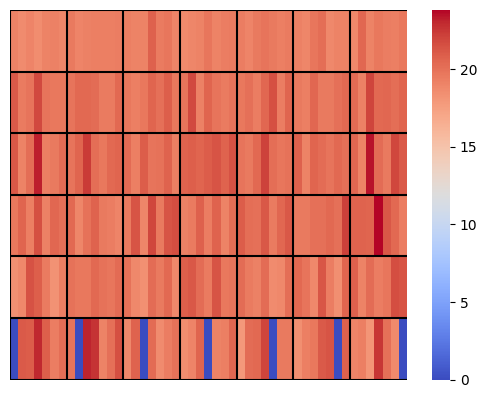

In [6]:
ax = sns.heatmap(avnew1,  
                 cmap = "coolwarm",
                 cbar = True,
                 yticklabels = False, 
                 xticklabels = False)
ax.hlines([0, 1, 2, 3, 4, 5, 6], *ax.get_xlim(), color = "black")
ax.vlines([0, 7, 14, 21, 28, 35, 42], *ax.get_ylim(), color = "black")
plt.show()

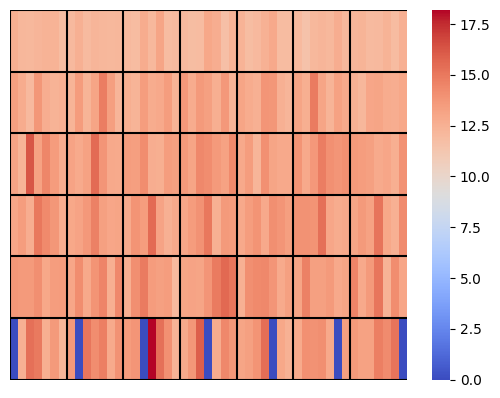

In [7]:
ax = sns.heatmap(avnew2,  
                 cmap = "coolwarm",
                 cbar = True,
                 yticklabels = False, 
                 xticklabels = False)
ax.hlines([0, 1, 2, 3, 4, 5, 6], *ax.get_xlim(), color = "black")
ax.vlines([0, 7, 14, 21, 28, 35, 42], *ax.get_ylim(), color = "black")
plt.show()

In [28]:
def Connect4QLearn(env, action_values, boardstate, getAgentStateFromXY, get_possible_actions, getNextState):
    env.reset()
    done = False
    state = 0
    while not done:
        # Player 1: User
        possible_actions, done = get_possible_actions(env, ncol, nrow, done)
        board_before = env.get_simple_slots()
        if done: 
            return([env, "No one won"])
        env.print()
        print("\n")
        text = "Choose an action from " + np.array2string(possible_actions + 1)
        action = input(text)
        action = int(action) - 1
        env.drop(Chip.YELLOW, action)
        state = getNextState(env.get_simple_slots(), board_before, boardstate, getAgentStateFromXY)
        victory = env.check_for_victory()
        if victory:
            done = True
            return([env, "Congrats, you won!"])

       # Player 2: Q Learned Machine
        possible_actions, done = get_possible_actions(env, ncol, nrow, done)
        board_before = env.get_simple_slots()
        if done: 
            return([env, "No one won"])
        env.print()
        print("\n")
        av = action_values[state]
        action = np.random.choice(np.flatnonzero(av == av.max()))
        env.drop(Chip.RED, action)
        state = getNextState(env.get_simple_slots(), board_before, boardstate, getAgentStateFromXY)
        victory = env.check_for_victory()
        if victory:
            done = True
            return([env, "The machine won!"])
        
    return([env, "Something unforseen happened"])
    

In [31]:
env, message = Connect4QLearn(env, action_values1, boardstate, getAgentStateFromXY, get_possible_actions, getNextState)
env.print()
print("\n" + message)


- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 



Choose an action from [1 2 3 4 5 6 7] 5



- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - Y - - 


- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - R Y - - 



Choose an action from [1 2 3 4 5 6 7] 5



- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - Y - - 
- - - R Y - - 


- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - R - - 
- - - - Y - - 
- - - R Y - - 



Choose an action from [1 2 3 4 5 6 7] 4



- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - R - - 
- - - Y Y - - 
- - - R Y - - 


- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - R - - 
- - - Y Y - - 
- R - R Y - - 



Choose an action from [1 2 3 4 5 6 7] 2



- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - R - - 
- Y - Y Y - - 
- R - R Y - - 


- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - R - - 
- Y - Y Y - - 
- R R R Y - - 



Choose an action from [1 2 3 4 5 6 7] 3



- - - - - - - 
- - - - - - - 
- - - - - - - 
- - - - R - - 
- Y Y Y Y - - 
- R R R Y - - 
Congrats, you won!
